# On-Device Continual Learning - EMNIST Classification

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import string
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from collections import defaultdict, Counter
import random

In [3]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## Model

### Load Dataset

In [4]:
(t_ds_train, t_ds_test), ds_info = tfds.load(
    'emnist/letters',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

ds_full = t_ds_train.concatenate(t_ds_test)
label_map = list(string.ascii_uppercase)

### Preprocess Dataset

In [5]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    # image = tf.expand_dims(image, -1)
    label = label - 1
    return image, label

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
buffer_size = ds_info.splits['train'].num_examples + ds_info.splits['test'].num_examples

ds_full = ds_full.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_full = ds_full.shuffle(buffer_size, reshuffle_each_iteration=True)

In [7]:
total = buffer_size
n_train = int(0.8 * total)
n_val   = int(0.1 * total)
n_test  = total - n_train - n_val

ds_train = ds_full.take(n_train)
rest = ds_full.skip(n_train)
ds_val = rest.take(n_val)
ds_test = rest.skip(n_val)

In [8]:
batch_size = 64

ds_train_proc = (
    ds_full
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

ds_val_proc = (
    ds_val
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

ds_test_proc = (
    ds_test
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

tf.data.Dataset.save(
    ds_test_proc,
    "../saved_ds/test_proc",
    compression=None
)

In [ ]:
## Print Numbre exambles in each set


# print("Train set:")
# ctr = Counter()
# for image, label in ds_train.map(preprocess).as_numpy_iterator():
#     ctr[int(label)] += 1

# for i in range(len(ctr)):
#     print(f"{i} ({label_map[i]}): {ctr[i]}")

# print("Validation set:")
# ctr = Counter()
# for image, label in ds_val.map(preprocess).as_numpy_iterator():
#     ctr[int(label)] += 1

# # Mostrem el resultat
# for i in range(len(ctr)):
#     print(f"{i} ({label_map[i]}): {ctr[i]}")

# print("Test set:")
# ctr = Counter()
# for image, label in ds_test.map(preprocess).as_numpy_iterator():
#     ctr[int(label)] += 1

# # Mostrem el resultat
# for i in range(len(ctr)):
#     print(f"{i} ({label_map[i]}): {ctr[i]}")



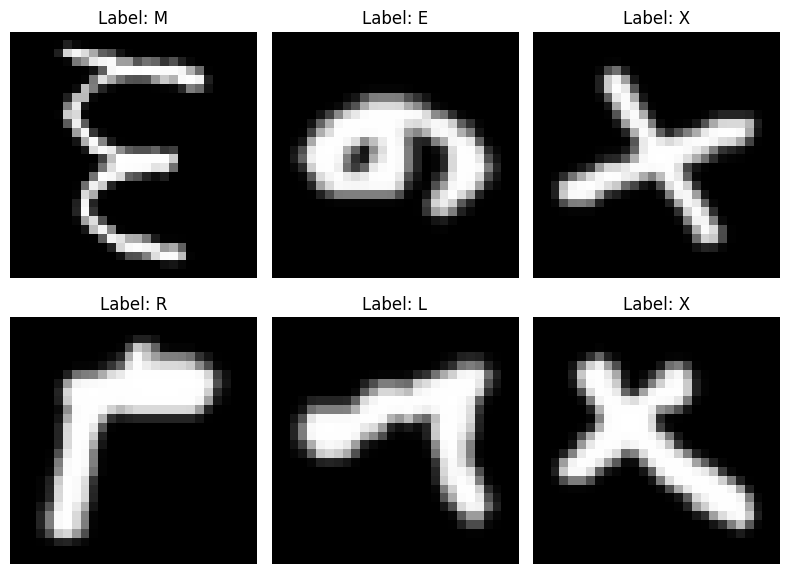

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(8, 6))
for i, example in enumerate(ds_train_proc.unbatch().take(6)):
    image, label = example
    ax = axes[i // 3, i % 3]
    ax.imshow(tf.squeeze(image), cmap='gray')

    label_str = label_map[label.numpy()]

    ax.set_title(f'Label: {label_str}')
    ax.axis('off')

plt.tight_layout()
plt.show()


### Model Definition

In [17]:
from tensorflow.keras import layers, models, optimizers, callbacks

def create_cil_model(input_shape=(28,28,1), num_classes=26):
    inp = layers.Input(input_shape)

    # -------- Bloc 1 --------
    x = layers.Conv2D(32, 3, padding='same', name='conv1')(inp)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Activation('relu', name='act1')(x)
    x = layers.Conv2D(32, 3, padding='same', name='conv1b')(x)
    x = layers.BatchNormalization(name='bn1b')(x)
    x = layers.Activation('relu', name='act2')(x)
    x = layers.MaxPool2D(2, name='pool1')(x)

    # -------- Bloc 2 --------
    x = layers.Conv2D(64, 3, padding='same', name='conv2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Activation('relu', name="act3")(x)
    x = layers.MaxPool2D(2, name='pool2')(x)

    # -------- Embedding --------
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(256, activation='relu', name='features1')(x)
    # x = layers.Dropout(0.5, seed=1337, name='drop1')(x)
    x = layers.Dense(128, activation='relu', name='features2')(x)
    # x = layers.Dropout(0.5, seed=1337, name='drop2')(x)

    # -------- Classificador -------- 
    logits = layers.Dense(num_classes, name='classifier')(x)
    out   = layers.Activation('softmax', name='probabilities')(logits)

    model = models.Model(inp, out)

    for name in ['conv1','bn1','act1','conv1b','bn1b','act2','pool1']:
        model.get_layer(name).trainable = False
    
    # for layer in model.layers:
    #     print(f"{layer.name:15} trainable={layer.trainable}")

    return model

### Training

In [41]:
model = tf.keras.models.load_model("../models/emnist_model.keras")

## Model Evaluation

In [ ]:
# Evaluate loss and accuracy
test_loss, test_acc = model.evaluate(ds_test_proc)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in ds_test_proc:
    probs = model.predict(images)
    preds = tf.argmax(probs, axis=1).numpy()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map, yticklabels=label_map)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report (Precision, Recall, F1):")
print(classification_report(y_true, y_pred, target_names=label_map))

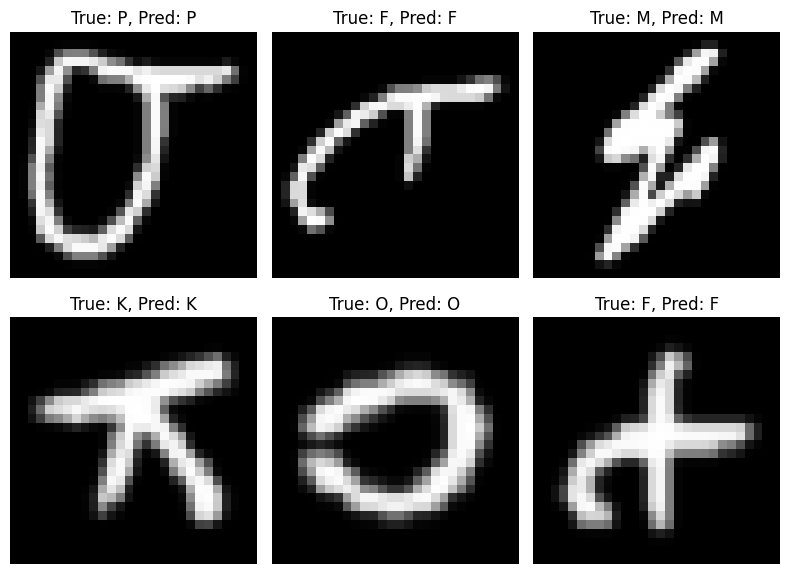

In [24]:
for images, labels in ds_test_proc.take(1):  # MUST be the preprocessed dataset
    predictions = model(images)
    pred_labels = tf.argmax(predictions, axis=1)
    
    fig, axes = plt.subplots(2, 3, figsize=(8, 6))
    for i in range(6):
        ax = axes[i // 3, i % 3]
        ax.imshow(tf.squeeze(images[i]), cmap='gray')

        true_char = label_map[labels[i].numpy()]           # 0–25 → 'A'–'Z'
        pred_char = label_map[pred_labels[i].numpy()]      # 0–25 → 'A'–'Z'

        ax.set_title(f'True: {true_char}, Pred: {pred_char}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### Save Model

In [ ]:
model.save("../models/emnist_model.keras")

## Model Wrap

### LittleRTModule

In [70]:
# INFERENCE and TRAINING

class LiteRTModule(tf.Module):
    def __init__(self, model, dropout_rate=0.5, dropout_seed=1337):
        super().__init__(name="LiteRT_CIL_Model")
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam()
        self.loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy()
        self.dropout_rate = dropout_rate
        self.dropout_seed = dropout_seed

        self.py_ckpt = tf.train.Checkpoint(model=self.model, optimizer=self.optimizer)
        self.py_ckpt_manager = None

    @tf.function(input_signature=[
        tf.TensorSpec([None, 28, 28, 1], tf.float32, name="images"),
        tf.TensorSpec([None], tf.int64, name="labels")
    ])
    def train(self, images, labels):
        # apply _stateless_ dropout here:
        images_drop = tf.nn.dropout(
            images,
            rate=self.dropout_rate,
            seed=self.dropout_seed
        )
        with tf.GradientTape() as tape:
            logits = self.model(images_drop, training=True)
            loss = self.loss_fn(labels, logits)
        
        trainable_vars = self.model.trainable_variables
        if not trainable_vars: # Defensive check
            tf.print("Warning: No trainable variables found in the model for LiteRTModule.train().")
            return {"loss": loss}
        
        grads = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(
            zip(grads, trainable_vars))
        return {"loss": loss}

    @tf.function(input_signature=[
        tf.TensorSpec([None, 28, 28, 1], tf.float32, name="images")
    ])
    def infer(self, images):
        probs = self.model(images, training=False)
        return {"probabilities": probs}
    
    def _ensure_model_built(self, sample_input_shape=(1, 28, 28, 1)):
        """
        Ensures the Keras model is built before export.
        The batch dimension in sample_input_shape should typically be 1 or None.
        """
        if not self.model.built:
            print(f"Model not built. Attempting to build with input_shape={sample_input_shape}...")
            try:
                if self.model._is_graph_network or isinstance(self.model, tf.keras.Sequential): # Functional or Sequential
                    self.model.build(input_shape=sample_input_shape)
                else: # Subclassed model - try calling it
                    # Create a compliant dummy input (ensure batch dimension matches what build expects)
                    dummy_input_tensor = tf.zeros(sample_input_shape, dtype=tf.float32)
                    _ = self.model(dummy_input_tensor)
                print("Model built successfully.")
            except Exception as e:
                print(f"ERROR: Failed to build model automatically with shape {sample_input_shape}: {str(e)}")
                print("Ensure the model is built (e.g., by training, evaluation, or an explicit model.build() call) before export.")
                raise
    
    def export_weights_for_c(self, custom_filepath="model_weights.dat"):
        """Exports model weights to a custom simple binary format for C applications."""
        self._ensure_model_built() # Ensure model is built so weights exist
        try:
            with open(custom_filepath, 'wb') as f:
                weights_to_save = self.model.weights # Export all weights
                num_tensors = len(weights_to_save)
                f.write(np.int32(num_tensors).tobytes())

                for var in weights_to_save:
                    var_name = var.name
                    var_data = var.numpy()
                    
                    name_bytes = var_name.encode('utf-8')
                    f.write(np.int32(len(name_bytes)).tobytes())
                    f.write(name_bytes)
                    
                    f.write(np.int32(var_data.ndim).tobytes())
                    for dim_size in var_data.shape:
                        f.write(np.int32(dim_size).tobytes())
                    
                    # Assuming float32 for C.
                    if var_data.dtype != np.float32:
                        # print(f"Info: Variable {var_name} is {var_data.dtype}, casting to float32 for export.")
                        var_data = var_data.astype(np.float32)
                    f.write(np.int32(0).tobytes()) # Data type identifier (0 for float32)
                    
                    f.write(var_data.tobytes())
            print(f"Exported {num_tensors} weight tensors to custom C format: {custom_filepath}")
            return {"status": "EXPORTED_FOR_C_SUCCESS", "path": custom_filepath}
        except Exception as e:
            print(f"ERROR exporting weights for C: {str(e)}")
            return {"status": f"EXPORTED_FOR_C_FAILED: {str(e)}", "path": None}

    def import_weights_from_c_format(self, custom_filepath="model_weights.dat"):
        """Imports model weights from the custom simple binary format."""
        self._ensure_model_built() # Ensure model is built to have target variables
        try:
            with open(custom_filepath, 'rb') as f:
                num_tensors_in_file = np.frombuffer(f.read(4), dtype=np.int32)[0]
                
                if num_tensors_in_file != len(self.model.weights):
                    raise ValueError(f"Tensor count mismatch. Model expects {len(self.model.weights)}, file has {num_tensors_in_file}")

                for i in range(num_tensors_in_file):
                    name_len = np.frombuffer(f.read(4), dtype=np.int32)[0]
                    name_from_file = f.read(name_len).decode('utf-8')
                    
                    ndim = np.frombuffer(f.read(4), dtype=np.int32)[0]
                    # Read the entire shape tuple at once
                    shape_from_file = tuple(np.frombuffer(f.read(ndim * np.dtype(np.int32).itemsize), dtype=np.int32))
                    
                    dtype_enum = np.frombuffer(f.read(4), dtype=np.int32)[0]
                    if dtype_enum != 0: # Assuming 0 for float32
                        raise ValueError(f"Unsupported data type enum {dtype_enum} in file for {name_from_file}")
                    
                    target_var = self.model.weights[i] # Assumes order in file matches model.weights
                    if target_var.name != name_from_file:
                        print(f"Warning: Name mismatch during import. Model var: {target_var.name}, File var: {name_from_file}. Assigning by order.")
                    if target_var.shape != shape_from_file:
                        raise ValueError(f"Shape mismatch for {target_var.name}. Model: {target_var.shape}, File: {shape_from_file}")

                    num_elements = np.prod(shape_from_file)
                    bytes_to_read = num_elements * np.dtype(np.float32).itemsize
                    data_from_file = np.frombuffer(f.read(bytes_to_read), dtype=np.float32).reshape(shape_from_file)
                    
                    target_var.assign(data_from_file)
            print(f"Imported {num_tensors_in_file} weight tensors from custom C format: {custom_filepath}")
            return {"status": "IMPORTED_FROM_C_SUCCESS"}
        except Exception as e:
            print(f"ERROR importing weights from C format: {str(e)}")
            return {"status": f"IMPORTED_FROM_C_FAILED: {str(e)}"}

    def export_to_tflite(self, tflite_model_path="model.tflite"):
        """Converts the Keras model to a TFLite model file (primarily for inference)."""
        self._ensure_model_built() # Ensure model is built
        try:
            converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
            # Optional: Add optimizations or configurations for TFLite
            # converter.optimizations = [tf.lite.Optimize.DEFAULT]
            tflite_model_data = converter.convert()

            with open(tflite_model_path, 'wb') as f:
                f.write(tflite_model_data)
            print(f"Exported TFLite model (for inference) to: {tflite_model_path}")
            return {"status": "TFLITE_EXPORT_SUCCESS", "path": tflite_model_path}
        except Exception as e:
            print(f"ERROR exporting to TFLite: {str(e)}")
            print("Ensure the Keras model is built and callable before TFLite conversion.")
            return {"status": f"TFLITE_EXPORT_FAILED: {str(e)}", "path": None}

### Create Wraped Model

In [72]:
litert_module = LiteRTModule(model)

### Save Model with Signatures

In [ ]:
c_path = "./model_exports_for_c/deployed_model_weights.dat"
export_status = litert_module.export_weights_for_c(custom_filepath=c_path)

if not export_status.get("status") == "EXPORTED_FOR_C_SUCCESS":
    raise RuntimeError(f"Export for C failed: {export_status.get('status')}")


export_tflite_status = litert_module.export_to_tflite(tflite_model_path="../models/emnist_litert_train2.tflite")
print(f"TFLite export status: {export_tflite_status}")

if not export_tflite_status.get("status") == "TFLITE_EXPORT_SUCCESS":
    raise RuntimeError(f"TFLite export failed: {export_tflite_status.get('status')}")

Exported 24 weight tensors to custom C format: ./model_exports_for_c/deployed_model_weights.dat
INFO:tensorflow:Assets written to: C:\Users\arnau\AppData\Local\Temp\tmpikuryc7l\assets


INFO:tensorflow:Assets written to: C:\Users\arnau\AppData\Local\Temp\tmpikuryc7l\assets


Saved artifact at 'C:\Users\arnau\AppData\Local\Temp\tmpikuryc7l'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  2786188206032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2786188207760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2786188209296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2786188207376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2786188208720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2786188209488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2786188211024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2786188211600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2786188211792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2786188210640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  27861

# Test

Test Inference

In [106]:
for images, labels in ds_test_proc.take(1):
    test_image = images[0]
    test_label = labels[0]
    test_image = tf.expand_dims(test_image, axis=0)

try:
    infer_output = litert_module.infer(tf.constant(test_image))
    probabilities = infer_output['probabilities']
    print(f"Inference output probabilities shape: {probabilities.shape}")
except Exception as e:
    print(f"❌ LiteRTModule Inference: Test FAILED with error: {str(e)}")

Inference output probabilities shape: (1, 26)


Test Training

In [124]:
trainable_weights_before_lrtm_train = []
if litert_module.model.trainable_weights:
    for w in litert_module.model.trainable_weights:
        trainable_weights_before_lrtm_train.append(w.numpy().copy())

    dummy_train_labels_lrt = np.random.randint(0, model.output_shape[-1], size=(1), dtype=np.int64)
    

    print("  Running a train step via LiteRTModule...")
    label_for_train = tf.constant([test_label.numpy()], dtype=tf.int64)
    loss_info = litert_module.train(tf.constant(test_image), label_for_train)


    print(f"  LiteRTModule train loss: {loss_info['loss'].numpy():.4f}")

    weights_changed = False
    if trainable_weights_before_lrtm_train:
        for i, w_before in enumerate(trainable_weights_before_lrtm_train):
            if not np.allclose(w_before, litert_module.model.trainable_weights[i].numpy()):
                weights_changed = True
                print(f"  Weight '{litert_module.model.trainable_weights[i].name}' changed after LiteRTModule.train().")
                break
        if weights_changed:
            print("  ✅ LiteRTModule Train method: Test SUCCEEDED (weights changed).")
        else:
            print("  ⚠️ LiteRTModule Train method: Test Result - Weights did NOT change (or no trainable vars). This might be expected if learning rate is tiny or gradients were zero.")
    else:   
        print("  Info: LiteRTModule Train method - No trainable weights in the model to check for changes.")
else:
    print("  Skipping LiteRTModule.train() test as model has no trainable variables.")


  Running a train step via LiteRTModule...
  LiteRTModule train loss: 1.0727
  Weight 'kernel' changed after LiteRTModule.train().
  ✅ LiteRTModule Train method: Test SUCCEEDED (weights changed).


Verify Export/Import

In [125]:
print("\n--- Step 5c (Optional): Verifying Custom C Format Export/Import ---")
#
temp_keras_model_for_export_test = create_cil_model(num_classes=model.output_shape[-1])

temp_keras_model_for_export_test.set_weights(model.get_weights())
temp_litert_module = LiteRTModule(model=temp_keras_model_for_export_test)


print(f"  Exporting to  for verification...")
verify_export_status = temp_litert_module.export_weights_for_c(custom_filepath="./model_exports_for_c/verify_model_weights.dat")

if verify_export_status.get("status") == "EXPORTED_FOR_C_SUCCESS":
    weights_at_verify_export_time = [w.numpy().copy() for w in temp_litert_module.model.weights]
    
    print("  Modifying weights in temp_litert_module before importing...")
    if temp_litert_module.model.weights:
        temp_litert_module.model.weights[0].assign(np.random.rand(*temp_litert_module.model.weights[0].shape).astype(np.float32))

    print(f"  Importing from C format file: ")
    import_c_status_verify = temp_litert_module.import_weights_from_c_format(custom_filepath="./model_exports_for_c/verify_model_weights.dat")
    print(f"  Import status: {import_c_status_verify}")

    if import_c_status_verify.get("status") == "IMPORTED_FROM_C_SUCCESS":
        all_match = True
        for i, w_orig in enumerate(weights_at_verify_export_time):
            if not np.allclose(w_orig, temp_litert_module.model.weights[i].numpy()):
                print(f"    Mismatch found in weight: {temp_litert_module.model.weights[i].name}")
                all_match = False
                break
        if all_match:
            print("  ✅ LiteRTModule Custom C Format Export/Import Verification: SUCCESSFUL!")
        else:
            print("  ❌ LiteRTModule Custom C Format Export/Import Verification: FAILED!")
    else:
        print("  Skipping C format import verification due to import failure.")
else:
    print("  Skipping C format import verification due to export failure for verification.")




--- Step 5c (Optional): Verifying Custom C Format Export/Import ---
  Exporting to  for verification...
Exported 24 weight tensors to custom C format: ./model_exports_for_c/verify_model_weights.dat
  Modifying weights in temp_litert_module before importing...
  Importing from C format file: 
Imported 24 weight tensors from custom C format: ./model_exports_for_c/verify_model_weights.dat
  Import status: {'status': 'IMPORTED_FROM_C_SUCCESS'}
  ✅ LiteRTModule Custom C Format Export/Import Verification: SUCCESSFUL!


## OLD

In [ ]:
tf.saved_model.save(
    litert_module,
    "../models/lit_saved_model",
    signatures={
        'train': litert_module.train,
        'infer': litert_module.infer
    }
)

### Convert to TFLitle

In [ ]:
COMMON_SUPPORTED_OPS = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

c_train = tf.lite.TFLiteConverter.from_saved_model(
    "../models/lit_saved_model",
    signature_keys=["train","infer"]
)
c_train.target_spec.supported_ops = COMMON_SUPPORTED_OPS
c_train.experimental_enable_resource_variables = True
tflite_train = c_train.convert()
open("../models/emnist_litert_train.tflite","wb").write(tflite_train)


c_infer = tf.lite.TFLiteConverter.from_keras_model(model)
c_infer.target_spec.supported_ops = [ tf.lite.OpsSet.TFLITE_BUILTINS ]
c_infer.experimental_enable_resource_variables = False
tflite_inf = c_infer.convert()
open("../models/emnist_litert_infer.tflite","wb").write(tflite_inf)

## Comparation

In [ ]:
interpreter = tf.lite.Interpreter(model_path="../models/emnist_litert_infer.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
x_all = []
y_all = []

# each x_batch is shape (64,28,28,1), each y_batch is (64,)
for x_batch, y_batch in ds_test_proc.take(2):  
    x_all.append(x_batch.numpy())
    y_all.append(y_batch.numpy())

x = np.concatenate(x_all, axis=0)  # -> (128,28,28,1)
y = np.concatenate(y_all, axis=0)  # -> (128,)

# Now exactly like before:
num_samples = 100
keras_logits = model.predict(x[:num_samples])
tflite_logits = []
for i in range(num_samples):
    sample = x[i : i+1].astype(np.float32)      # already has leading batch dim
    interpreter.set_tensor(input_details[0]['index'], sample)
    interpreter.invoke()
    tflite_logits.append(interpreter.get_tensor(output_details[0]['index'])[0])
tflite_logits = np.stack(tflite_logits, axis=0)

keras_preds  = np.argmax(keras_logits, axis=1)
tflite_preds = np.argmax(tflite_logits, axis=1)
keras_acc    = np.mean(keras_preds  == y[:num_samples])
tflite_acc   = np.mean(tflite_preds == y[:num_samples])
avg_diff     = np.mean(np.abs(keras_logits - tflite_logits))
max_diff     = np.max (np.abs(keras_logits - tflite_logits))

print("📊 Model Comparison Summary")
print(f"✅ Keras Accuracy:      {keras_acc:.4f}")
print(f"✅ TFLite Accuracy:     {tflite_acc:.4f}")
print(f"📉 Avg Logit Delta:     {avg_diff:.2e}")
print(f"📈 Max Logit Delta:     {max_diff:.2e}")
